In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pygam import LinearGAM, s
from datetime import datetime, timedelta

# Parameters

In [2]:
data_folder     = '../data'
input_folder    = '../output_files'
output_folder   = '../output_files'

num_forecast_days = 0 

In [3]:
df_mun_info = pd.read_csv(f'{data_folder}/geoinfo_municipios_colombia.csv')[['COD_DEPTO','NOM_DEPART']].drop_duplicates().sort_values(by='COD_DEPTO')

In [4]:
df_mun = pd.read_csv(f'{data_folder}/geoinfo_municipios_colombia.csv')

In [6]:
df_mun

,COD_MUN,NOM_MUNICI,COD_DEPTO,NOM_DEPART,STABBR
537,15798,TENZA,15,BOYACÁ,BOY


# Community interventions

In [91]:
selected_columns = ['date', 'replicate', 'community_trend', 'State', 'state_name']

df_interventions = pd.DataFrame({})
for departamento in df_mun_info.to_numpy()[:-1]:
    dept_code, dept_name = tuple(departamento)

    mobility_file = f'{input_folder}/mobility_trends/{dept_code}_mobility_trends.csv'

    # Load mobility data
    df = pd.read_csv(mobility_file)
    df['day'] = df.index.to_list()
    df['date'] = pd.to_datetime(df['date'])

    # Fit a GAM model
    gam = LinearGAM(s(0)).fit(df['day'], df['mobility_trend'])

    # Create a DataFrame for predictions
    df_fit = pd.DataFrame({
        'day': range(0, df['day'].iloc[-1] + num_forecast_days + 1)
    })

    # Predict using the fitted model
    df_fit['community_trend'] = gam.predict(df_fit['day'])

    # Merge the original data with the predictions
    df_fit = df_fit.merge(df[['day', 'mobility_trend']], on='day', how='left')
    df_fit['date'] = df_fit['day'].apply(lambda x: df['date'].iloc[0] + timedelta(days=x))

    # Add info to match Guido's output
    df_fit['community_trend'] += 1 - max(df_fit['community_trend'] )
    df_fit['replicate'] = 1
    df_fit['State'] = dept_code
    df_fit['state_name'] = dept_name

    df_interventions = pd.concat([df_interventions, df_fit[selected_columns]])

In [92]:
df_interventions.to_csv(f'{output_folder}/interventions/interventions_covid_timevarying_community_baseline.csv', index=False)
df_interventions.to_csv(f'{output_folder}/interventions/interventions_covid_timevarying_community.csv', index=False)

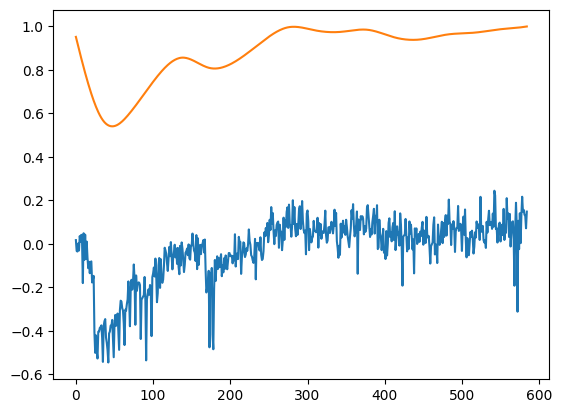

In [93]:
plt.plot(df_fit.mobility_trend)
plt.plot(df_fit.community_trend)

# Shelter interventions

In [94]:
shelter_file = f'{input_folder}/shelter_trends/{dept_code}_shelter_trends.csv'

# Load mobility data
df = pd.read_csv(shelter_file)
df['day'] = df.index.to_list()
df['date'] = pd.to_datetime(df['date'])

In [95]:
selected_columns = ['date', 'replicate', 'shelter_trend', 'State', 'state_name']

df_interventions = pd.DataFrame({})
for departamento in df_mun_info.to_numpy()[:-1]:
    dept_code, dept_name = tuple(departamento)

    shelter_file = f'{input_folder}/shelter_trends/{dept_code}_shelter_trends.csv'

    # Load mobility data
    df = pd.read_csv(shelter_file)
    df['day'] = df.index.to_list()
    df['date'] = pd.to_datetime(df['date'])
    df['shelter_trend_'] = df['shelter_trend']
    del df['shelter_trend']

    # Fit a GAM model
    gam = LinearGAM(s(0)).fit(df['day'], df['shelter_trend_'])

    # Create a DataFrame for predictions
    df_fit = pd.DataFrame({
        'day': range(0, df['day'].iloc[-1] + num_forecast_days + 1)
    })

    # Predict using the fitted model
    df_fit['shelter_trend'] = gam.predict(df_fit['day'])

    # Merge the original data with the predictions
    df_fit['date'] = df_fit['day'].apply(lambda x: df['date'].iloc[0] + timedelta(days=x))

    # Add info to match Guido's output
    df_fit['replicate'] = 1
    df_fit['State'] = dept_code
    df_fit['state_name'] = dept_name

    df_interventions = pd.concat([df_interventions, df_fit[selected_columns]])

In [96]:
df_interventions.to_csv(f'{output_folder}/interventions/interventions_covid_timevarying_shelter_baseline.csv', index=False)

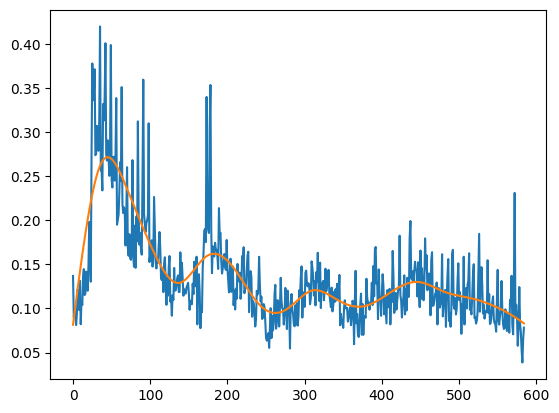

In [97]:
plt.plot(df.shelter_trend_)
plt.plot(df_fit.shelter_trend)

In [123]:
num_forecast_days = 0  # Adjust as needed for forecasting

selected_columns = ['date', 'replicate', 'shelter_trend', 'State', 'state_name']
df_interventions = pd.DataFrame({})

for departamento in df_mun_info.to_numpy()[:-1]:
    dept_code, dept_name = tuple(departamento)
    shelter_file = f'{input_folder}/shelter_trends/{dept_code}_shelter_trends.csv'

    # Load mobility data
    df = pd.read_csv(shelter_file)
    df['day'] = df.index
    df['date'] = pd.to_datetime(df['date'])
    df['shelter_trend_'] = df['shelter_trend']  # Normalize to a scale of 1
    del df['shelter_trend']

    # Define periods for different models
    pre_xmas_end = datetime.strptime('2020-12-10', '%Y-%m-%d')
    post_xmas_start = datetime.strptime('2020-12-25', '%Y-%m-%d')
    pre_xmas = df[df['date'] <= pre_xmas_end].copy()
    post_xmas = df[df['date'] >= post_xmas_start].copy()
    all_periods = [pre_xmas, post_xmas]

    # Fit and predict for each period
    for period_df in all_periods:
        if not period_df.empty:
            gam = LinearGAM(s(0)).fit(period_df['day'], period_df['shelter_trend_'])
            period_df['shelter_trend'] = gam.predict(period_df['day'])
    
    # Combine predictions
    combined_df = pd.concat(all_periods, ignore_index=True).sort_values('day')
    
    # June reopening adjustment
    june_reopen_date = datetime.strptime('2021-06-08', '%Y-%m-%d')
    combined_df.loc[combined_df['date'] >= june_reopen_date, 'shelter_trend'] *= 1.2  # Example multiplicative adjustment
    combined_df['shelter_trend'] = combined_df['shelter_trend'].clip(0, 1)  # Cap values at 1

    # Prepare final DataFrame
    combined_df['date'] = combined_df['day'].apply(lambda x: df['date'].iloc[0] + timedelta(days=x))
    combined_df['replicate'] = 1
    combined_df['State'] = dept_code
    combined_df['state_name'] = dept_name

    df_interventions = pd.concat([df_interventions, combined_df[selected_columns]])

df_interventions.reset_index(drop=True, inplace=True)

# Save or further process df_interventions as needed


/zine/HPC02S1/ex-dveloza/mambaforge/envs/sktime/lib/python3.10/site-packages/pygam/pygam.py:1150: RuntimeWarning: divide by zero encountered in scalar divide
  r2['explained_deviance'] = 1.0 - full_d.sum() / null_d.sum()


In [124]:
df_interventions.to_csv(f'{output_folder}/interventions/interventions_covid_timevarying_shelter.csv', index=False)
df_interventions.to_csv(f'{output_folder}/interventions/interventions_covid_timevarying_shelter_lockdown.csv', index=False)

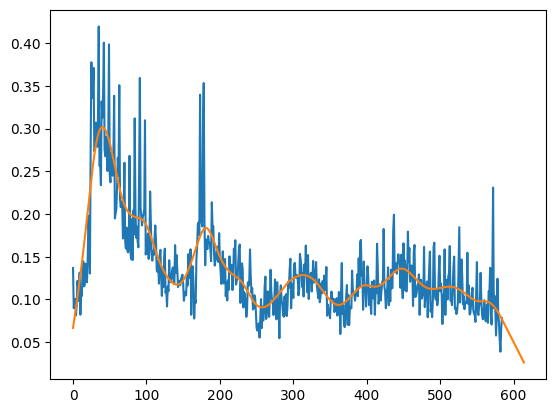

In [126]:
plt.plot(df.shelter_trend_)
plt.plot(combined_fit.day, combined_fit.shelter_trend)